Read csv and split for replicates

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

def subset_data_to_replicates(data_folder):
    # use peaks of triangular voltage to subset replicates

    # CH2 is applied voltage, CH1 is result from photodiode
    df_CH2 = pd.read_csv(str(data_folder + "F0001CH2.CSV"), delimiter=",", header=0,
                         names=["info_1", "info_2", "empty_1", "time", "value", "empty_2"])
    df_CH1 = pd.read_csv(str(data_folder + "F0001CH1.CSV"), delimiter=",", header=0,
                         names=["info_1", "info_2", "empty_1", "time", "value", "empty_2"])

    # find points where voltage changes incline/decline
    maxima = sp.signal.find_peaks(df_CH2["value"], distance=500)[0]
    minima = sp.signal.find_peaks(-df_CH2["value"], distance=500)[0]
    split_points = np.sort(np.concatenate((maxima, minima)))

    print("plot of splits")
    plt.plot(df_CH2["time"], df_CH2["value"])
    plt.plot(df_CH1["time"], df_CH1["value"])
    plt.scatter(df_CH2["time"][split_points], df_CH2["value"][split_points])
    plt.scatter(df_CH1["time"][split_points], df_CH1["value"][split_points])
    plt.show()

    # dataframe with all subsets combined
    combined_df = pd.DataFrame()

    for i in range(np.shape(split_points)[0]-1):

        # subset interval between split points
        interval_length = split_points[i+1]+1 - split_points[i]
        subset_time = df_CH2["time"][split_points[0]:split_points[0]+interval_length]
        subset_CH2 = df_CH2["value"][split_points[i]:split_points[i+1]+1]
        subset_CH1 = df_CH1["value"][split_points[i]:split_points[i+1]+1]

        # check if voltage is increasing over time
        if subset_CH2.iloc[0] < subset_CH2.iloc[-1]:
            # relic from flipping to combine up/down
            #subset_CH2 = subset_CH2[::-1]
            #subset_CH1 = subset_CH1[::-1]

            # reset indices
            subset_time = subset_time.reset_index(drop=True)
            subset_CH2 = subset_CH2.reset_index(drop=True)
            subset_CH1 = subset_CH1.reset_index(drop=True)

            # create dataframe of subsets
            subset_df = pd.DataFrame({
                'time': subset_time,
                'CH2_value': subset_CH2,
                'CH1_value': subset_CH1
            })

            # append to combined dataframe
            combined_df = pd.concat([combined_df, subset_df])

    return(combined_df)

plot of splits


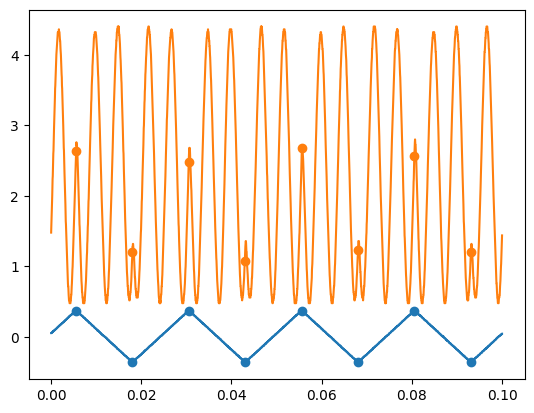

plot of replicate data
linear fit
a: 58.83826 +/- 0.034084 b: -0.68731 +/- 0.000422
sin fit
a: 1.931643 +/- 0.004462 w: 1236.694694 +/- 0.626536 p: -3.457298 +/- 0.007857 y: 2.416439 +/- 0.003153


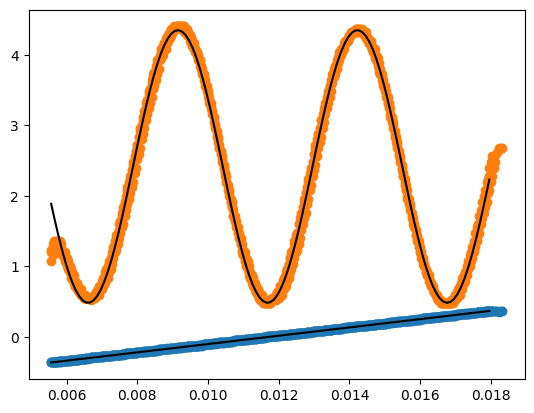

In [16]:
# analysis for horizontal polarization
data = subset_data_to_replicates("ALL0001_horizontal_pol/")

# plot result, see systematic deviation between flipped and unflipped
print("plot of replicate data")
plt.scatter(data["time"], data["CH2_value"])
plt.scatter(data["time"], data["CH1_value"])


# compute fits over replicate data
print("linear fit")
popt, pcov = sp.optimize.curve_fit(lambda t,a,b: a*t+b, data["time"], data["CH2_value"])
popt, pcov_sqr = np.round(popt, decimals=6), np.round(np.sqrt(np.diag(pcov)), decimals=6)
print("a:", popt[0], "+/-", pcov_sqr[0], "b:", popt[1], "+/-", pcov_sqr[1])

t = np.arange(data["time"].iloc[0], data["time"].iloc[-1], 0.0001)
plt.plot(t, popt[0]*t+popt[1], color = "black")

print("sin fit")
popt, pcov = sp.optimize.curve_fit(lambda t,a,w,p,y: a*np.sin(w*t+p)+y, data["time"], data["CH1_value"], p0=[2, 1e3, 8e-3, 2.5])
popt, pcov_sqr = np.round(popt, decimals=6), np.round(np.sqrt(np.diag(pcov)), decimals=6)
print("a:", popt[0], "+/-", pcov_sqr[0], "w:", popt[1], "+/-", pcov_sqr[1],
      "p:", popt[2], "+/-", pcov_sqr[2], "y:", popt[3], "+/-", pcov_sqr[3])

plt.plot(t, popt[0]*np.sin(popt[1]*t + popt[2])+popt[3], color = "black")